In [1]:
### Ref: https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb


# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# For basic Image IO
import IPython.display as display
from PIL import Image

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [81]:
def show_batch(image_batch, label_batch):
    print("image_batch_shape {}".format(image_batch.shape))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n])
        #plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [73]:
def show_batch_grayscale(image_batch, label_batch):
    print("image_batch_shape {}".format(image_batch.shape))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.squeeze(image_batch[n]), cmap='gray',interpolation='none')
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [6]:
#This assumed that you have checked out the data repo next to the object detection repo
# Data repo can be found over here: https://github.com/nandini-sundar/CS230-TrashNet-YOLO-Labeled
import pathlib
data_dir = pathlib.Path("../CS230-TrashNet-YOLO-Labeled")

In [7]:
data_images_dir = data_dir.joinpath("Images")
CLASS_NAMES = np.array([item.name for item in data_images_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['plastic', 'metal', 'glass', '.DS_Store', 'paper', 'trash',
       'cardboard'], dtype='<U9')

In [8]:
image_count = len(list(data_images_dir.glob('*/*.jpg')))
image_count

2527

In [9]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [10]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [87]:
def get_dataframe_for_generator(filename, x_col, y_col):
    df = pd.read_csv(data_dir.joinpath(filename), names=[x_col])
    
    #Convert foldernames in filepaths to class names.
    #Expects filepath in format : ./Images/paper/paper283.jpg
    df[y_col] = df[x_col].apply(lambda x: os.path.basename(os.path.dirname(x)))
    return df
    
x_col = "filename"
y_col = 'class_list'

train_df = get_dataframe_for_generator(filename='train.txt', x_col=x_col, y_col=y_col)
print("Here are some train images ")
print(train_df)

test_df = get_dataframe_for_generator(filename='test.txt', x_col=x_col, y_col=y_col)
print("Here are some test images ")
print(test_df)


Here are some train images 
                             filename class_list
0         ./Images/paper/paper283.jpg      paper
1         ./Images/paper/paper297.jpg      paper
2         ./Images/paper/paper526.jpg      paper
3         ./Images/paper/paper240.jpg      paper
4         ./Images/paper/paper254.jpg      paper
...                               ...        ...
2270  ./Images/plastic/plastic405.jpg    plastic
2271  ./Images/plastic/plastic411.jpg    plastic
2272  ./Images/plastic/plastic377.jpg    plastic
2273  ./Images/plastic/plastic439.jpg    plastic
2274  ./Images/plastic/plastic388.jpg    plastic

[2275 rows x 2 columns]
Here are some test images 
                            filename class_list
0         ./Images/paper/paper70.jpg      paper
1        ./Images/paper/paper123.jpg      paper
2         ./Images/paper/paper65.jpg      paper
3        ./Images/paper/paper280.jpg      paper
4        ./Images/paper/paper445.jpg      paper
..                               ...        

In [76]:
train_data_gen = image_generator.flow_from_dataframe(dataframe=train_df,
                                                     directory=data_dir,
                                                     x_col=x_col_name,
                                                     y_col=y_col_name,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    class_mode='raw')

Found 2275 validated image filenames.


In [77]:
# train_data_gen = image_generator.flow_from_directory(directory=str(data_images_dir),
#                                                      batch_size=BATCH_SIZE,
#                                                      shuffle=True,
#                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                      classes = list(CLASS_NAMES))

In [78]:
image_batch, label_batch = next(train_data_gen)
image_batch.shape

(32, 224, 224, 3)

In [79]:
label_batch

array(['metal', 'paper', 'glass', 'plastic', 'glass', 'glass', 'metal',
       'paper', 'glass', 'glass', 'cardboard', 'cardboard', 'plastic',
       'glass', 'plastic', 'glass', 'paper', 'glass', 'cardboard',
       'plastic', 'cardboard', 'paper', 'paper', 'paper', 'glass',
       'metal', 'plastic', 'plastic', 'glass', 'trash', 'paper', 'metal'],
      dtype=object)

image_batch_shape (32, 224, 224, 3)


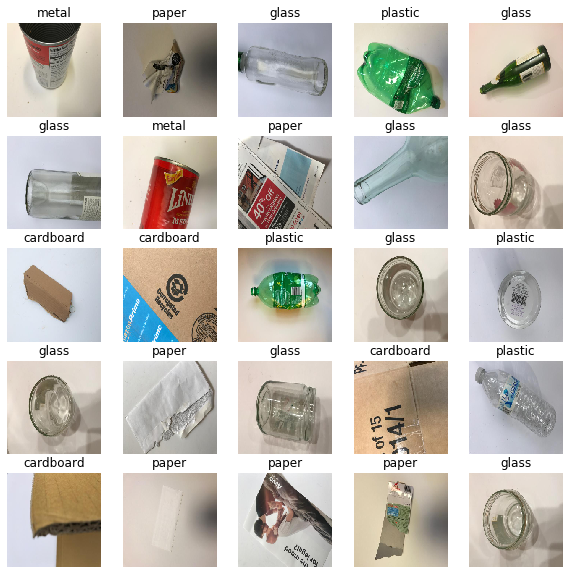

In [82]:
show_batch(image_batch, label_batch)

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

In [ ]:
Y_proba = model.predict(image_batch)

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(image_batch)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()